In [1]:
from astropy.stats import sigma_clip, SigmaClip, gaussian_fwhm_to_sigma, bootstrap
import numpy as np
from astropy.modeling import models, fitting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
x = np.array((1.0,2.,3,4,5))
y = x+0.4*np.random.random(size=len(x))
yerr = np.random.random(size=len(x))*0.25 + 0.05

In [3]:
from astropy.table import Table

In [6]:
AT2=Table.read('/Users/emir/Dropbox/FLOWS/flows/phot_workdir/2020oij/01418/photometry.ecsv')
AT2.remove_row(0)
AT2['ind']=np.arange(len(AT2['mag']))
AT=Table(AT2[['ind','H_mag','mag','mag_error']],names=['ind','mag_cat','mag_inst','err_inst'])
x = AT['mag_cat']#[2:]
y = AT['mag_inst']#[2:]
yerr = AT['err_inst']#[2:]

In [58]:
AT2.meta

OrderedDict([('targetid', 10),
             ('version', 'dev_clean-v0.1.post126+git40abc15'),
             ('fileid', 1418),
             ('template', None),
             ('diffimg', None),
             ('photfilter', 'H'),
             ('fwhm', <Quantity 4.21293693 pix>),
             ('pixel_scale', <Quantity 0.23450379 arcsec / pix>),
             ('seeing', <Quantity 0.98794968 arcsec>),
             ('obstime-bmjd', 59047.11226613053),
             ('zp', 23.03386447191017),
             ('zp_error', 0.13019353430857677)])

In [7]:
AT2

starid,ra,decl,pm_ra,pm_dec,gaia_mag,gaia_bp_mag,gaia_rp_mag,gaia_variability,B_mag,V_mag,H_mag,J_mag,K_mag,u_mag,g_mag,r_mag,i_mag,z_mag,distance,pixel_column,pixel_row,used_for_epsf,flux_aperture,flux_aperture_error,flux_psf,flux_psf_error,pixel_column_psf_fit,pixel_row_psf_fit,pixel_column_psf_fit_error,pixel_row_psf_fit_error,mag,mag_error,ind
,deg,deg,mas / yr,mas / yr,,,,,,,,,,,,,,,deg,pix,pix,,ct / s,ct / s,ct / s,ct / s,pix,pix,pix,pix,,,
int64,float64,float64,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
159453280980045501,328.09800402,42.87905328,-5.87,-8.91,13.044,13.715,12.27,2,14.613,13.401,11.228,11.228,10.513,nan,13.904,13.031,12.652,12.457,0.0336393061163926,251.89230290645457,396.36036225740395,True,25505.102974766418,21.19015246428836,24387.83790344215,687.0773651664688,252.6994437959303,397.6015271962745,0.07075407763684098,0.06572824326975647,12.06593122248152,0.13373857395544847,0
159453280784673124,328.07846781,42.87707201,-3.71,-4.64,13.005,13.189,12.686,2,13.416,13.036,12.333,12.333,12.094,nan,13.152,13.037,13.038,13.077,0.0446282266675932,221.85529539670802,176.8335697075658,True,13185.91900067191,15.230576317059294,16247.266394921262,104.74147739845311,222.32737233752536,177.41173987484896,0.01617676679854985,0.015030933926786366,12.506913718541124,0.13038154932728346,1
159433280752749998,328.0752743,42.86613423,-3.06,-8.76,16.679,17.331,15.917,2,17.854,16.839,14.909,14.909,14.299,nan,17.511,16.637,16.289,16.111,0.0540789597881267,53.820664268265546,140.8910726238658,True,1799.4523015850225,6.224527294555065,2278.084459278995,21.16327934656089,54.150004584449185,141.72046681530787,0.023380170060556045,0.02171750462058499,14.6399399184712,0.13058366068736402,2
159483280650285700,328.06502876,42.90421847,-1.77,-2.69,16.183,16.561,15.641,2,16.897,16.353,15.037,15.037,14.65,nan,16.604,16.178,15.993,15.923,0.0431308991011272,639.394372190875,26.015345633168238,True,1338.6854094294542,5.344676414735375,1574.5866397149782,5.629133403195799,640.2191429751718,26.09807796358546,0.008981573807174027,0.008396919824958908,15.040948066520816,0.1302513815580134,3
159443280637758819,328.06377596,42.87348472,-2.91,-2.3,16.372,16.787,15.796,2,17.378,16.676,15.101,15.101,14.662,nan,16.845,16.36,16.154,16.079,0.055221107949889,167.06573122979682,11.71769496162267,True,1282.5825662864534,5.434084738842336,1606.5255257295228,15.960759747670362,167.2832998355409,12.191349875203226,0.024941356890798568,0.023284370766725956,15.01914539603134,0.1306396193985183,4
159533280831745953,328.08317443,42.94609642,-7.07,-6.83,16.668,17.076,16.091,2,17.676,16.811,15.421,15.421,15.004,nan,17.135,16.661,16.447,16.358,0.0492205806882781,1282.614757719085,229.98538910253848,True,880.8603559568138,4.956428780583545,913.5629144956346,13.580045830308402,1283.1212109922349,230.61060427735796,0.03740588778865062,0.03464918636345764,15.63201831853054,0.13119007683113956,5
159463280720554881,328.07205566,42.88686936,-6.64,-5.37,17.113,17.661,16.419,2,17.488,17.053,15.573,15.573,15.102,nan,17.773,17.068,16.793,16.67,0.0428653288372896,372.5816692718739,104.83887850807628,True,890.7390622404525,4.7816926272486935,1066.7751153383665,19.275947099030727,373.0877362738368,105.21850318045693,0.04550919593150272,0.04230076758763634,15.46368228103712,0.13166337511720014,6
159533280835690037,328.08356941,42.94116595,-2.89,-3.17,17.494,18.137,16.724,2,nan,nan,15.621,15.621,15.097,nan,18.298,17.484,17.098,16.904,0.0452021072198725,1206.8277464691237,234.40019919981813,True,805.0594278431993,4.771216417022077,869.7653512989039,9.498264227145276,1207.4629518917848,235.2011789584525,0.02737947387639294,0.02557212236629539,15.685359215022306,0.13073231970334373,7


In [8]:
import pandas as pd
#pd.DataFrame()

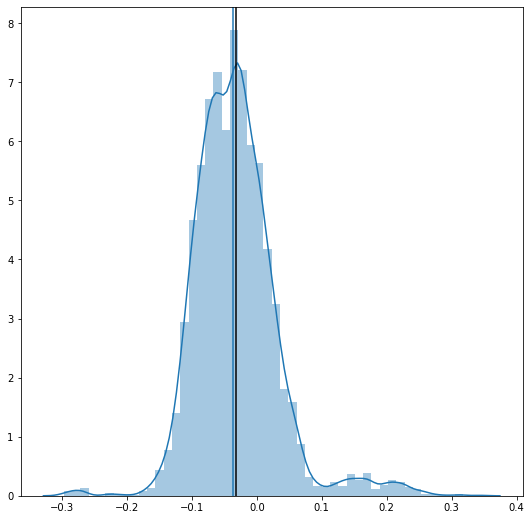

In [53]:
from scipy.special import erfcinv
#Calculate sigma for sigma clipping
def sigma_from_Chauvenet(Nsamples):
    '''Calculate sigma according to the Cheuvenet criterion'''
    return erfcinv(1./(2*Nsamples)) * (2.)**(1/2)

n=5000
bootstraps=bootstrap(AT['ind'],bootnum=n)
bootstraps.sort()
bootinds=bootstraps.astype(int)
model = models.Linear1D(slope=1.0,fixed={'slope':True})
outlier_kwargs={'sigma':sigma_from_Chauvenet(len(AT['ind']))}
fitter = fitting.FittingWithOutlierRemoval(fitting.LinearLSQFitter(), sigma_clip, **outlier_kwargs)
#fitter = fitting.LinearLSQFitter()
#fitter = fitting.LevMarLSQFitter()
ints = np.ones(len(bootinds),dtype=np.float64) 
#fig,ax = plt.subplots()

#clipped = []

#clipped = []

for i,bs in enumerate(bootinds):
    w=(1.0/yerr[bs])**2
    #w=np.ones(len(yerr[bs]),dtype=np.float64)
    #best_fit = fitter(model, x[bs], y[bs], weights=w)
    best_fit, sigma_clipped = fitter(model, x[bs], y[bs], weights=w)
    ints[i] = best_fit.intercept.value
    #if bs[sigma_clipped].size > 0:
    #    for b in bs[sigma_clipped]:
    #        clipped.append(b)
    #    #[clipped.append(b) for b in bs[sigma_clipped]]
    #clipped.add_row(sigma_clipped)
    #clipped.append(bs[sigma_clipped])

#np.mean(ints)
#np.median(ints)
fig,ax=plt.subplots(figsize=(9,9))
sns.distplot(ints, ax=ax)
ax.axvline(np.mean(ints),color='black')
ax.axvline(np.median(ints))

In [56]:
ints.sort()
print(np.nanmedian(ints),np.std(ints))

-0.03670785839029989 0.06428884960460056


In [57]:
np.nanpercentile(ints,50+68.27/2),np.nanpercentile(ints,50-68.27/2)

(0.017567140026660977, -0.08895305080185212)

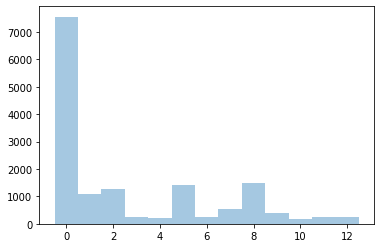

In [59]:
S=pd.Series(clipped)
S.value_counts()
sns.distplot(S,kde=False,bins=np.arange(14)-0.5)

<IPython.core.display.Javascript object>


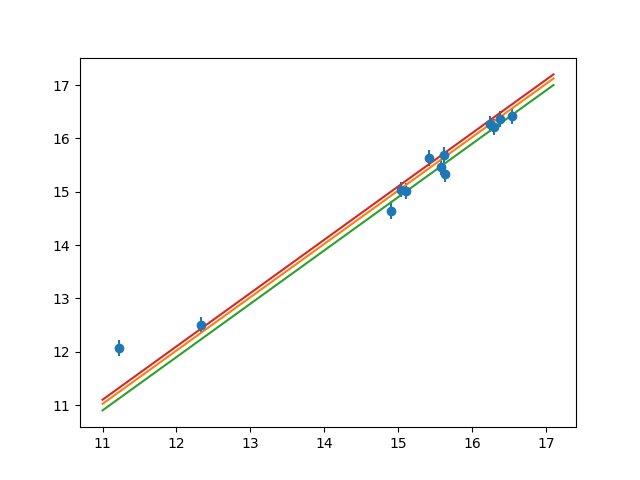

In [112]:
plt.figure()
plt.errorbar(AT['mag_cat'],AT['mag_inst'],AT['err_inst'],linestyle='None',marker='o')
model.intercept = np.median(ints)
plt.plot(np.linspace(11,17.1),model(np.linspace(11,17.1)))
model.intercept = -0.1
plt.plot(np.linspace(11,17.1),model(np.linspace(11,17.1)))
model.intercept = 0.1
plt.plot(np.linspace(11,17.1),model(np.linspace(11,17.1)))

In [7]:
parnames = ['intercept','test']
pars={}

for par in parnames:
    pars[par]=np.ones(len(bootinds), dtype=np.float64)
pars

[np.nanmedian(pars[par]) for par in pars]

#bp=best_fit.parameters[np.array(best_fit.param_names) == parname][0]

[1.0, 1.0]

In [8]:
pars = {}
parnames = ['intercept']
[pars[par]=np.ones(len(bootinds), dtype=np.float64) for par in parnames]
pars

SyntaxError: invalid syntax (<ipython-input-8-c8bce628663a>, line 3)

In [24]:
weights[sigma_clipped] = 0
weights

array([1., 1., 1., 1., 1.])

In [30]:
N=len(weights.nonzero()[0])
N

5

In [20]:
weights = w
weights[sigma_clipped] = 0 # Trick to make following expression simpler
N = len(weights.nonzero())
N

1

In [429]:
model

<Linear1D(slope=1., intercept=0.06722017)>

In [418]:
model

<Linear1D(slope=1., intercept=1.)>

In [267]:
n = 3
bootstraps=bootstrap(AT['ind'],bootnum=n)
bootstraps.sort()
bootinds=bootstraps.astype(int)
model=models.Polynomial1D(1,c1=np.ones(n),fixed={'c1':True},n_models=n)
#fitter=fitting.SLSQPLSQFitter()
fitter=fitting.LinearLSQFitter()
fit=fitter(model,x[bootinds].T,y[bootinds])#,
           #weights=(1.0/yerr[bootinds].reshape(len(x),n))**2)
#fitter = fitting.FittingWithOutlierRemoval(fitting.LinearLSQFitter(), sigma_clip, sigma=3.0)
#best_fit, sigma_clipped = fitter(model, x[bootinds], y[bootinds], weights=(1.0/yerr[bootinds])**2)


ValueError: Polynomial1D gives unsupported >2D derivative matrix for this x/y

In [279]:
x[bootinds][np.newaxis, :]

array([[[1., 2., 2., 3., 4.],
        [1., 2., 4., 5., 5.],
        [1., 1., 2., 3., 4.]]])

In [290]:
y[bootinds][0]

array([1.1488364 , 2.36869844, 2.36869844, 3.2870604 , 4.3093803 ])

In [300]:
line1d=models.Linear1D(slope=np.ones(n),intercept=np.zeros(n),fixed={'slope':True},model_set_axis=1)
fitter=fitting.LinearLSQFitter()
model = fitter(model=line1d,x=x[bootinds],y=y[bootinds])

InputParameterError: All parameter values must be arrays of dimension at least 2 for model_set_axis=1 (the value given for 'slope' is only 1-dimensional)

In [269]:
line1d

<Linear1D(slope=[1., 1., 1.], intercept=[0., 0., 0.])>

In [255]:
fit.c0.value

array([2., 4., 1.])

In [234]:
fit(np.arange(3))

array([2., 5., 3.])

In [230]:
Y=fit(np.arange(3), model_set_axis=False)

array([[2., 3., 4.],
       [4., 5., 6.],
       [1., 2., 3.]])

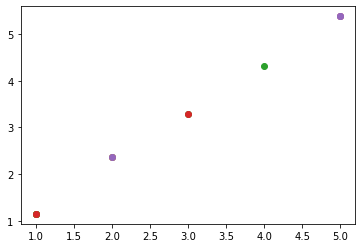

In [224]:
plt.plot(x[bootinds],y[bootinds],marker='o',linestyle='None')
plt.plot()

In [218]:
np.dstack((x[bootinds],y[bootinds])).shape

(3, 5, 2)

In [147]:
x[bootinds].reshape(5,3)

array([[1., 2., 3.],
       [5., 5., 1.],
       [3., 3., 4.],
       [4., 2., 2.],
       [2., 3., 5.]])

In [117]:
fit=fitter(model,x[bootinds], y[bootinds],weights=(1.0/yerr[bootinds])**2)



In [102]:
# Fit linear function with fixed slope, using sigma-clipping:
model = models.Linear1D(slope=1, fixed={'slope': True})
fitter = fitting.FittingWithOutlierRemoval(fitting.LinearLSQFitter(), sigma_clip, sigma=3.0)

best_fit, sigma_clipped = fitter(model, x[bootinds[0]], y[bootinds[0]], weights=(1.0/yerr[bootinds[0]])**2)
best_fit.intercept.value

<ErrorbarContainer object of 3 artists>

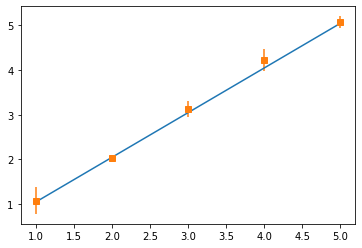

In [18]:
import matplotlib.pyplot as plt
plt.plot(x,best_fit(x))
plt.errorbar(x,y,yerr,linestyle='None',marker='s')

In [371]:
p = models.Polynomial1D(1, n_models=2, model_set_axis=0)

x = np.arange(0,4)

# Generate data for fitting 2 models and re-stack them along the last axis:
y = np.array([2*x+1, x+4])
y = np.moveaxis(y, 0, -1)



In [372]:
x1=np.arange(0,4)
x2=np.arange(0,4)
x3=np.vstack((x1,x2))
x1,x2,x3

(array([0, 1, 2, 3]),
 array([0, 1, 2, 3]),
 array([[0, 1, 2, 3],
        [0, 1, 2, 3]]))

In [382]:
f = fitting.LinearLSQFitter()
fit = f(p, x3, y.T)
#print(fit.parameters)

ValueError: Polynomial1D gives unsupported >2D derivative matrix for this x/y

In [356]:
fit

<Polynomial1D(1, c0=[[1., 4.]], c1=[[2., 1.]], n_models=2)>